## Lab 2: final challenges

__Вам предлагается решить задачу классификации сигналов или задачу классификации изображений. Или обе ;)__

__Выполнение этих заданий не является обязательным, но позитивно повлияет на вашу итоговую оценку. Успехов!__


### Part 4. HAR classification with raw data (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.


Данное задание составлено на основе данного [поста](https://burakhimmetoglu.com/2017/08/22/time-series-classification-with-tensorflow/). С помощью вручную сгенерированных фичей и классических подходов задача распознования движений была решена с точностью 96%. 

Также будет полезным изучить [вот этот](https://github.com/healthDataScience/deep-learning-HAR), а так же [вот этот репозиторий](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition), где к данной задаче рассматривается несколько подходов.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import pylab
import warnings as w
import os

%matplotlib inline

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size':14})

Вернемся к задаче классификации движений на основе [данных](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) из репозитория UCI ([прямая ссылка на скачивание](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)). 

В этот раз будем работать с исходными, а не предобработанными данными. Данные представляют собой сигналы с гироскопа и акселерометра, закрепленного на теле человека. Каждому семплу соотвествует 9 связанных временных рядов.

В начале приведена визуализация данных на основе PCA над вручную сгенерированными признаками. Для отрисовки графиков (цвет и легенда) нам также понадобятся метки классов.

In [ ]:
X_train_with_engineered_features = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "X_train.txt"))
y_train = np.genfromtxt(os.path.join("UCI HAR Dataset", "train", "y_train.txt"))

y_train_list = list(y_train)
X_unique = np.array([X_train_with_engineered_features[y_train_list.index(l)]
                             for l in sorted(list(set(y_train)))])

legend_labels = ["WALKING", "WALKING.UP", "WALKING.DOWN", "SITTING", "STANDING", "LAYING"]
colors_list = ['red', 'blue', 'green', 'orange', 'cyan', 'magenta']
mapped_colors = [colors_list[int(i)-1] for i in y_train]

from sklearn.decomposition import PCA
pca = PCA()

X_train_pca = pca.fit_transform(X_train_with_engineered_features)

plt.figure(figsize=(15,10))
pylab.scatter(X_train_pca[:, 0], X_train_pca[:, 1],
             c=mapped_colors)
plt.grid()
for idx, x in enumerate(pca.transform(X_unique)):
    plt.scatter(x[0], 
                x[1], 
                c=colors_list[idx], 
                label=legend_labels[idx])
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()

#### Предобработка данных
Предобработка сделана за нас автором [данного репозитория](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition). Будьте осторожны с путями.

In [ ]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

DATA_PATH = "./"

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)

TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    os.path.join(*[DATASET_PATH, TRAIN, "Inertial Signals/", signal+"train.txt"]) for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    os.path.join(*[DATASET_PATH, TEST, "Inertial Signals/", signal+"test.txt"]) for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = os.path.join(DATASET_PATH, TRAIN, "y_train.txt")
y_test_path = os.path.join(DATASET_PATH, TEST, "y_test.txt")

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)

In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")

#### Построение сети и эксперименты. (100% +)

__Ваша задача - построить сеть, которая решит задачу классификации с точностью (`accuracy`) не менее 86%.__
Разбалловка следующая:
* $=$86% - 2 points
* $>=$89% - 2.5 points
* $>=$91% - 3 points


__Warning!__ В сети существует несколько решений данной задачи с использованием различных фреймворков. При проверке это будет учитываться, так что свое решение нужно будет объяснить. Пожалуйста, не копируйте бездумно код, такие задания будут оценены 0 баллов. Если задача не решается - можете обратиться к заданию по классификации изображений.

После выполнения задания заполните небольшой отчет об экспериментах вида "Я пробовал(а) ... подходы и получил(а) ... результаты. Наконец, после N+1 чашки кофе/бессонной ночи у меня получилось, и весь секрет был в ..."

In [ ]:
# Your experiments here

### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [1]:
!wget https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip
!unzip -q data.zip

--2021-12-18 16:02:34--  https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/vgqpz2f1lolxmlv/data.zip [following]
--2021-12-18 16:02:34--  https://www.dropbox.com/s/raw/vgqpz2f1lolxmlv/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb26488e9135af1fb55ecb3eff.dl.dropboxusercontent.com/cd/0/inline/BcHId3gRu01ZHVuTJpHgddfdijdxMLWG_OwOikT2g8JU2L-u81_B7xMbv2IOF5buEztHXQfdMjHQFQu8DUANvXQyHrvwt3hv2g37QrmCXfT7Fo1fzbmwxzEzZ3SLhwBvod2UQ4-D2SLlRlEDJv9wOqAj/file# [following]
--2021-12-18 16:02:35--  https://uccb26488e9135af1fb55ecb3eff.dl.dropboxusercontent.com/cd/0/inline/BcHId3gRu01ZHVuTJpHgddfdijdxMLWG_OwOikT2g8JU2L-u81_B7xMbv2IOF5buEztHXQfdMjHQFQu8DUANvXQyHrvwt3hv2g37Qr

<h2> 0. Creating dataloaders <h2>

In [165]:
import torch
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import time

from torchvision import transforms, models
from torchsummary import summary
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

DEVICE = torch.device("cuda") if train_on_gpu else torch.device("cpu")

CUDA is available!  Training on GPU ...


In [13]:
TRAIN_DIR = Path('data/train/')
TEST_DIR = Path('data/test/')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpeg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpeg')))

In [19]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

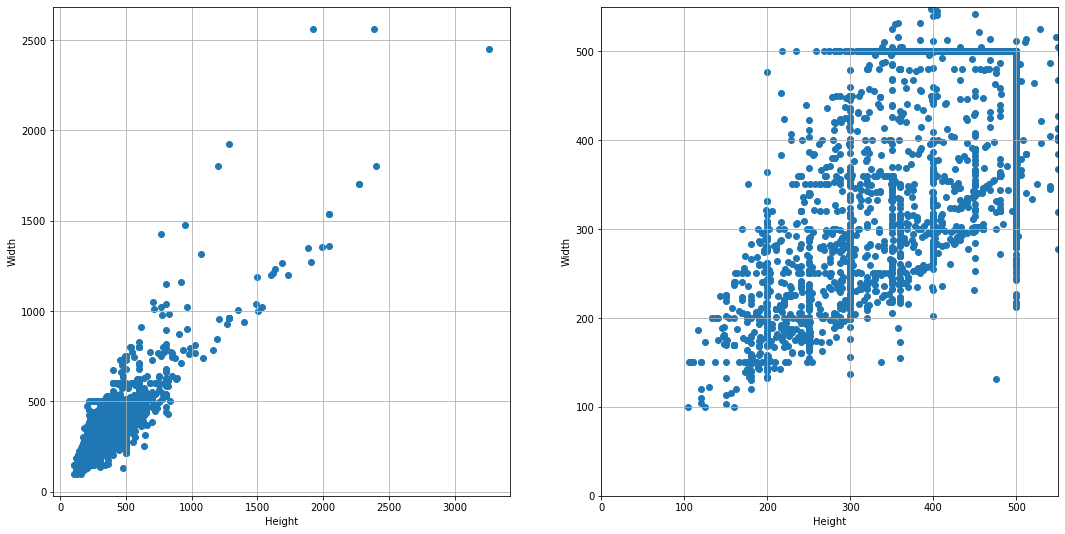

In [80]:
# Изучим размеры изображений train-датасета
import imagesize


img_sizes = []
for file in train_val_files: 
    height, width = imagesize.get(file)
    img_sizes.append([height, width])

img_sizes = np.array(img_sizes).T

fig, axes = plt.subplots(1, 2, figsize=(18, 9))

axes[0].scatter(img_sizes[0], img_sizes[1])
axes[0].set_xlabel("Height")
axes[0].set_ylabel("Width")
axes[0].grid(True)

axes[1].scatter(img_sizes[0], img_sizes[1])
axes[1].set_xlabel("Height")
axes[1].set_ylabel("Width")
axes[1].set_xlim(0, 550)
axes[1].set_ylim(0, 550)
axes[1].grid(True)

plt.show()

In [151]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 300
BATCH_SIZE = 16
N_CLASSES = 50

IMG_MEAN = [0.485, 0.456, 0.406]
IMG_STD = [0.229, 0.224, 0.225]

In [76]:
class MyDataset(Dataset):
    def __init__(self, files, transforms, mode):
        super().__init__()

        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.transforms = transforms
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        x = self.load_sample(self.files[index])
        x = self.transforms(x)

        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y


In [152]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(RESCALE_SIZE),
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(degrees=20),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
        transforms.Normalize(IMG_MEAN, IMG_STD)
    ]),
    'val': transforms.Compose([
        transforms.CenterCrop(RESCALE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(IMG_MEAN, IMG_STD)
    ]),
}

train_dataset = MyDataset(train_files, data_transforms['train'], mode='train')
val_dataset = MyDataset(val_files, data_transforms['val'], mode='val')

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

test_dataset = MyDataset(test_files, data_transforms['val'], mode='test')
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, shuffle=False)

In [84]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(IMG_MEAN)
    std = np.array(IMG_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)

    if title is not None:
        plt_ax.set_title(title)
        
    plt_ax.grid(False)

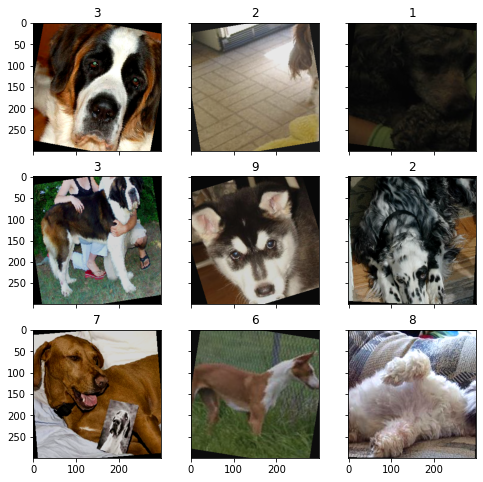

In [86]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_ind = int(np.random.uniform(0, 1000))
    im_val, label = train_dataset[random_ind]
    imshow(im_val.data.cpu(), title=label, plt_ax=fig_x)

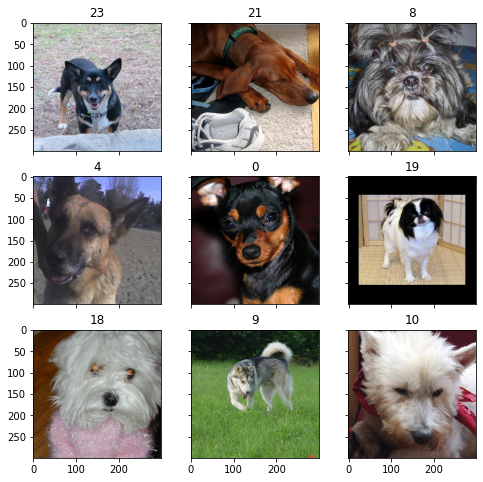

In [79]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_ind = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_ind]
    imshow(im_val.data.cpu(), title=label, plt_ax=fig_x)

<h2> 1. Функции обучения <h2>

In [159]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum() / y_pred.numel()


def predict_to_batch(output):
    return torch.argmax(output, 1)


def score_model_on_batch(metric, output, Y_batch):
    Y_pred = predict_to_batch(output)
    score = metric(Y_pred, Y_batch).mean().item()
    return score


def score_model(model, metric, data):
    scores = 0
    model.eval()

    for X_batch, Y_label in data:
        X_batch = X_batch.to(DEVICE)
        Y_label = Y_label.to(DEVICE)

        with torch.no_grad():
            output = model.forward(X_batch)
            scores += score_model_on_batch(metric, output, Y_label)

    return scores / len(data)

In [93]:
def train_loop(model, opt, loss_fn, data_tr, verbose, metric):
    avg_loss, avg_quality = 0, 0

    for X_batch, Y_batch in data_tr:
        model.train()
        # data to device
        X_batch = X_batch.to(DEVICE)
        Y_batch = Y_batch.to(DEVICE)
        # set parameter gradients to zero
        opt.zero_grad()
        # forward
        output = model.forward(X_batch)
        loss = loss_fn(output, Y_batch) # forward-pass
        loss.backward()  # backward-pass
        opt.step()  # update weights

        # calculate loss and accuracy to show the user
        avg_loss += loss.item() / len(data_tr)
        if verbose:
            model.eval()
            quality = score_model_on_batch(metric, output, Y_batch)
            avg_quality += quality / len(data_tr)

    return avg_loss, avg_quality

In [94]:
def val_loop(model, loss_fn, data_val, verbose, metric):
    avg_loss, avg_quality = 0, 0
    model.eval()

    for X_batch, Y_batch in data_val:
        # data to device
        X_batch = X_batch.to(DEVICE)
        Y_batch = Y_batch.to(DEVICE)
        # Disable gradients computation
        with torch.no_grad():
            # forward
            output = model.forward(X_batch)
            loss = loss_fn(output, Y_batch) # forward-pass

        if verbose:
            quality = score_model_on_batch(metric, output, Y_batch)
            avg_quality += quality / len(data_val)

        # calculate loss and accuracy to show the user
        avg_loss += loss.item() / len(data_val)

    return avg_loss, avg_quality

In [175]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, verbose=False, 
          lr_scheduler=None, metric=accuracy):
    tr_losses, tr_quality = [], []
    val_losses, val_quality = [], []

    start_time, prev_epoch_time = time.time(), time.time()

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        ep_tr_loss, ep_tr_quality = train_loop(model, opt, loss_fn, data_tr, 
                                               verbose, metric)

        ep_val_loss, ep_val_quality = val_loop(model, loss_fn, data_val, 
                                               verbose, metric)
        
        if lr_scheduler != None:
            lr_scheduler.step()
        
        tr_losses.append(ep_tr_loss)
        val_losses.append(ep_val_loss)

        if verbose:
            tr_quality.append(ep_tr_quality)
            val_quality.append(ep_val_quality)

        ep_spent_time = time.time() - prev_epoch_time
        spent_time = time.time() - start_time

        print("The epoch lasted: {:.0f}m {:.0f}s".format(ep_spent_time // 60, 
                                                         ep_spent_time % 60))
        print("The train lasted: {:.0f}m {:.0f}s".format(spent_time // 60, 
                                                         spent_time % 60))

        prev_epoch_time = time.time()
            
    if verbose:
        return tr_losses, val_losses, tr_quality, val_quality
    else:
        return tr_losses, val_losses

<h2> 2. Обучаемая модель -- ResNext <h2>  

ResNext = Inception + ResNet + Group-свёртки

Из Inception-а взята идея об использовании свёрток различных размеров. Поскольку размеры животных сильно варьируются от картинки к картинке, то использование ядра фиксированного размера будет не столь эффективно, поэтому лучше отдельно применять фильтры разных размеров и конкатенировать полученные результаты.  

Из ResNet-а взяты Residual Connections, которые позволяют бороться с проблемой затухания градиента.

Group-свёртки позволяют уменьшить число параметров нашей сети благодаря распараллеливанию процесса обучения

In [148]:
resnext = models.resnext50_32x4d(pretrained=True).to(DEVICE)
summary(resnext, input_size=(3, 300, 300), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 150, 150]           9,408
       BatchNorm2d-2         [16, 64, 150, 150]             128
              ReLU-3         [16, 64, 150, 150]               0
         MaxPool2d-4           [16, 64, 75, 75]               0
            Conv2d-5          [16, 128, 75, 75]           8,192
       BatchNorm2d-6          [16, 128, 75, 75]             256
              ReLU-7          [16, 128, 75, 75]               0
            Conv2d-8          [16, 128, 75, 75]           4,608
       BatchNorm2d-9          [16, 128, 75, 75]             256
             ReLU-10          [16, 128, 75, 75]               0
           Conv2d-11          [16, 256, 75, 75]          32,768
      BatchNorm2d-12          [16, 256, 75, 75]             512
           Conv2d-13          [16, 256, 75, 75]          16,384
      BatchNorm2d-14          [16, 256,

In [176]:
from torch import optim


for param in resnext.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 2048

resnext.fc = nn.Sequential(
    nn.Linear(num_features, 500, bias=False), 
    nn.BatchNorm1d(500), 
    nn.LeakyReLU(), 
    nn.Linear(500, N_CLASSES)
).to(DEVICE)

epochs = 24
loss_fn = nn.CrossEntropyLoss()
opt_params = resnext.fc.parameters()
optimizer = optim.Adam(opt_params, lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.15)

In [177]:
tr_losses, val_losses, tr_acc, val_acc = train(resnext, 
                                               optimizer, 
                                               loss_fn, 
                                               epochs, 
                                               train_loader, 
                                               val_loader, 
                                               verbose=True, 
                                               lr_scheduler=exp_lr_scheduler)

* Epoch 1/24
####################### Epoch 0 #######################
The epoch lasted: 2m 29s
The train lasted: 2m 29s
* Epoch 2/24
####################### Epoch 1 #######################
The epoch lasted: 2m 28s
The train lasted: 4m 57s
* Epoch 3/24
####################### Epoch 2 #######################
The epoch lasted: 2m 29s
The train lasted: 7m 26s
* Epoch 4/24
####################### Epoch 3 #######################
The epoch lasted: 2m 28s
The train lasted: 9m 54s
* Epoch 5/24
####################### Epoch 4 #######################
The epoch lasted: 2m 27s
The train lasted: 12m 21s
* Epoch 6/24
####################### Epoch 5 #######################
The epoch lasted: 2m 25s
The train lasted: 14m 46s
* Epoch 7/24
####################### Epoch 6 #######################
The epoch lasted: 2m 26s
The train lasted: 17m 11s
* Epoch 8/24
####################### Epoch 7 #######################
The epoch lasted: 2m 26s
The train lasted: 19m 37s
* Epoch 9/24
####################### Epoch 8

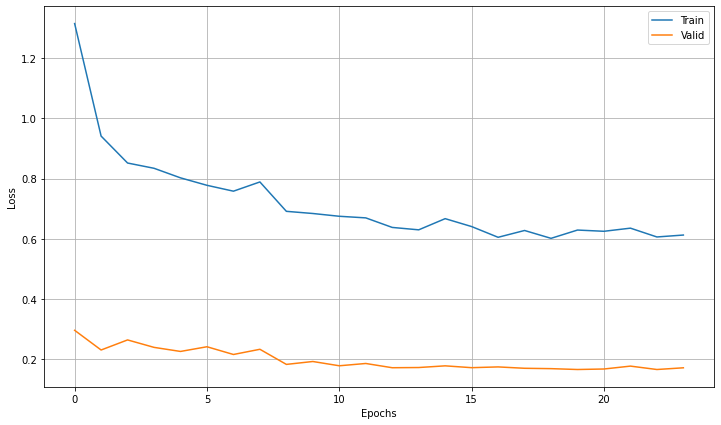

In [178]:
# Loss
plt.figure(figsize=(12, 7))

plt.plot(tr_losses, label="Train")
plt.plot(val_losses, label="Valid")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

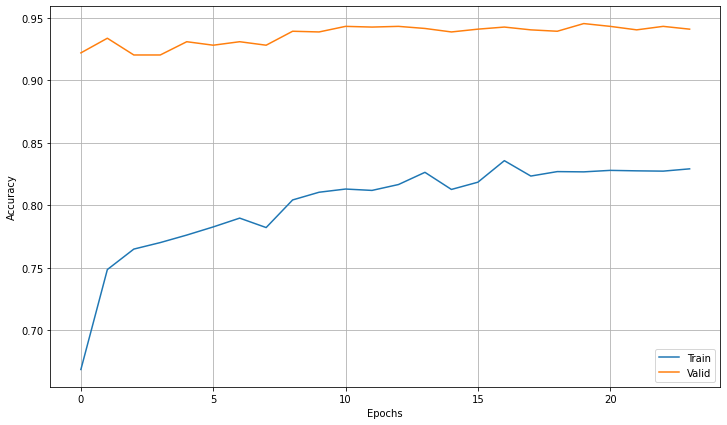

In [179]:
# Accuracy
plt.figure(figsize=(12, 7))

plt.plot(tr_acc, label="Train")
plt.plot(val_acc, label="Valid")

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [184]:
torch.save(resnext.state_dict(), "resnext_state")

In [225]:
def pred_loop(model, data_ts):
    model.eval()
    preds = np.array([])

    for X_batch in data_ts:
        X_batch = X_batch.to(DEVICE)

        with torch.no_grad():
            output = model.forward(X_batch)
            batch_preds = predict_to_batch(output)
            preds = np.append(preds, batch_preds.cpu().numpy())

    return preds

In [226]:
test_preds = pred_loop(resnext, test_loader)
test_filenames = list(map(lambda path: path.name, test_files))

In [240]:
encoded = [str(i) for i in range(N_CLASSES)]
decoded = train_dataset.label_encoder.transform(encoded)

translator = dict(zip(decoded, np.arange(N_CLASSES)))

In [246]:
with open("test_labels.csv", "w") as file_obj:
    for filename, pred in zip(test_filenames, test_preds):
        file_obj.write(f"{filename}, {translator[int(pred)]}\n")

**Upgrade: GradInit**  

<i>Идея:<i> перед началом обучения умножаем все веса слоев на константы: для каждого слоя константа своя. Константы инициализируем единицами. Далее проводим несколько итераций обучения, обновляя с помощью град. спуска только эти константы: остальные параметры сети при этом заморожены. После этого фиксируем константы и обучаем сеть как обычно. 

In [180]:
# TODO